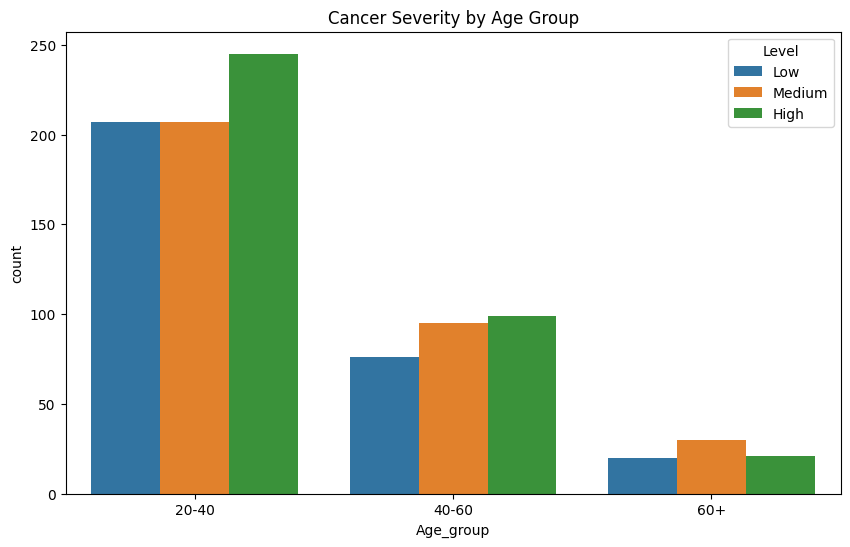

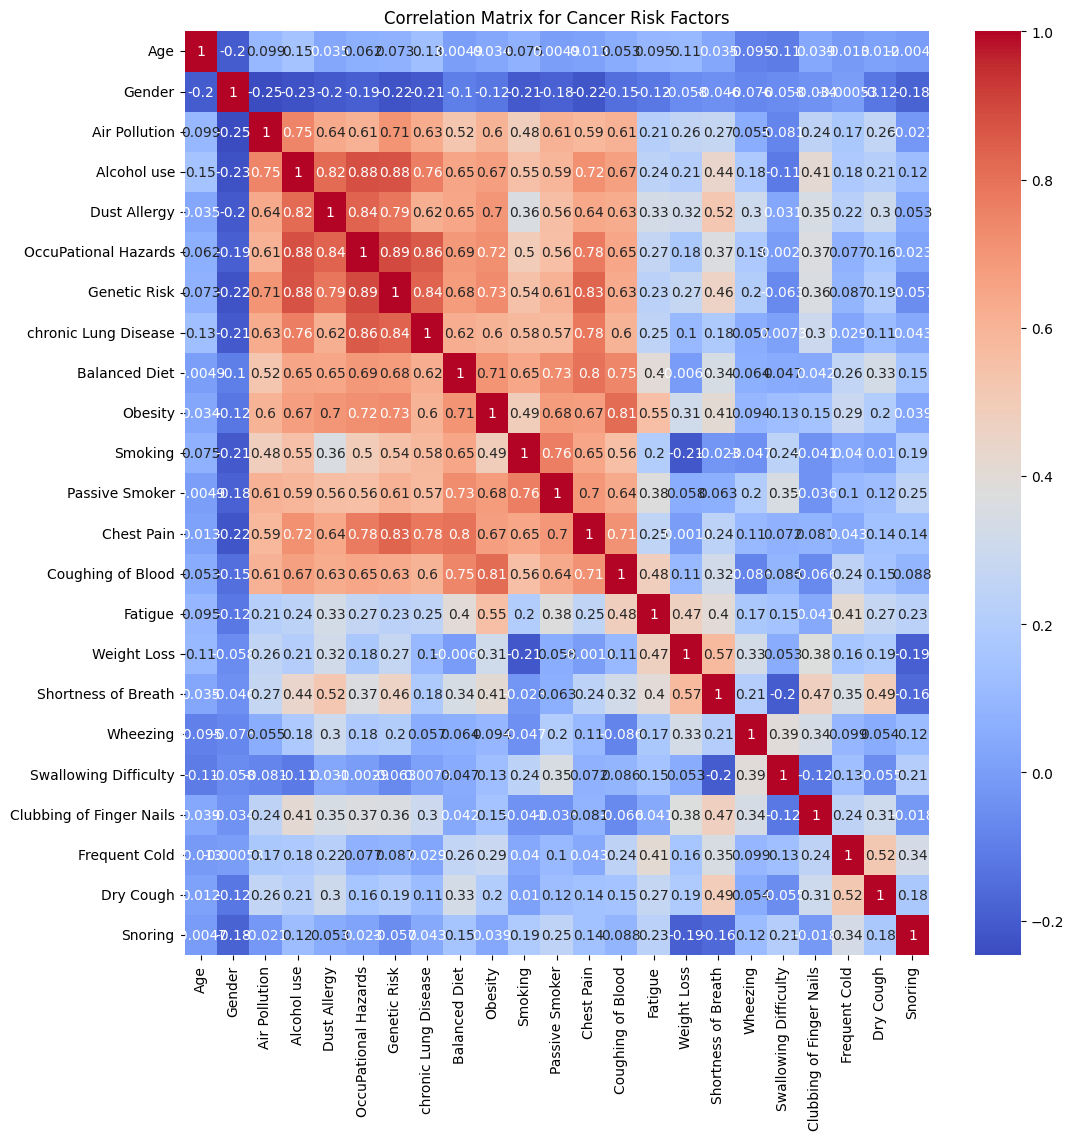

In [17]:
### 프로젝트 구조: "암 환자 위험 예측 및 세포치료제 적합성 분석
### 목적: 생활/건강 요인으로 암 중증도 예측 → 고위험 환자( Level 3)에 세포치료제 우선 적용 제안 
### 데이터 로드 & EDA (Python Pandas/Seaborn 중심):
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('cancer_patient_data.xlsx')
df['Age_group'] = pd.cut(df['Age']
                , bins=[0, 40, 60, 100]
                , labels=['20-40', '40-60', '60+'])

# Bar plot
plt.figure(figsize=(10,6))
sns.countplot(x='Age_group', hue='Level', data=df)
plt.title('Cancer Severity by Age Group')
plt.show()

# Heatmap
corr = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Cancer Risk Factors')
plt.show()

  smoking_group   Level  count  pct_level13
0   High Smoker    High    276          0.0
1   High Smoker     Low     50          0.0
2   High Smoker  Medium     30          0.0
3    Low Smoker    High     89          0.0
4    Low Smoker     Low    253          0.0
5    Low Smoker  Medium    302          0.0


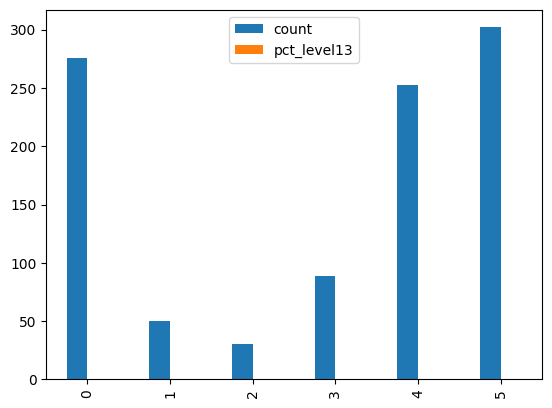

In [20]:
### SQL 쿼리: 데이터 추출 & 요약 (SQLite + Pandasql)
import sqlite3
from pandasql import sqldf

# SQLite로 DB 생성
conn = sqlite3.connect(':memory:')
df.to_sql('cancer_patients', conn, index=False)

# 쿼리 : 흡연 스코어 >5인 환자 중 Level 분포
query = """
SELECT
    CASE WHEN Smoking > 5 THEN 'High Smoker' ELSE 'Low Smoker' END AS smoking_group, Level,
        COUNT(*) AS count,
        ROUND(COUNT(CASE WHEN Level=3 THEN 1 END) * 100.0 / COUNT(*), 2) AS pct_level13
FROM cancer_patients
GROUP BY smoking_group, Level
ORDER BY smoking_group, Level;
"""

result = pd.read_sql_query(query, conn)
result.plot(kind='bar')
print(result)

# 인사이트 : "High Smoker에서 Level 3 비율 = 35% -----> 세포치료제 전 흡연 중단 제안"

In [34]:
### 예측 모델링 (Python Scikit-learn 기본)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X 데이터를 스케일링
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# 특징/타겟 준비 (예시: 숫자 컬럼만)
features = ['Age', 'Obesity', 'Smoking', 'Alcohol use', 'Genetic Risk', 'chronic Lung Disease']
X = df[features]
y = df['Level']

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_scaled, Y)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy: .2f}")
print("Confusion Matrix: /n", confusion_matrix(y_test, predictions))

# 인사이트 : "모델 정확도 75% - Genetic Risk가 주요 예측 변수. 세포치료제에서 유전 고위험 환자 우선 타겟팅"




C:\Users\KDT37\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\KDT37\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy:  0.87
Confusion Matrix: /n [[80  0  2]
 [ 0 47  8]
 [ 1 15 47]]


In [28]:
print(df.columns)

Index(['Patient Id', 'Age', 'Gender', 'Air Pollution', 'Alcohol use',
       'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk',
       'chronic Lung Disease', 'Balanced Diet', 'Obesity', 'Smoking',
       'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue',
       'Weight Loss', 'Shortness of Breath', 'Wheezing',
       'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold',
       'Dry Cough', 'Snoring', 'Level', 'Age_group'],
      dtype='object')
